# FDCHP Data Processing

This Notebook demonstrates how to process FDCHP data using the tools in the `ooi-data-explorations.python.examples.fdchp` library.

This requires setting up a python environment that contains the necessary dependencies to use in this notebook.

Alongside the base repository containing this Notebook (the location of the `ooi-data-explorations` repository, clone the `mi-instrument` repo 

```
git clone https://github.com/joffreyp/mi-instrument.git
```

Create a new python virtual environment:

```
cd ~
mkdir .venv
python -m venv ~/.venv
source .venv/bin/activate
```

Install mi-instrument requirements:

```
pip install -r mi-instrument/requirements_py3.txt
```

Install `ooi-data-explorations` and `mi-instruments`: 

```
pip install -e ooi-data-explorations/python/
pip install -e mi-instrument/
```

Prepare environment for use by Jupyter Notebook kernel:

```
pip install ipykernel
pip install ipympl
python -m ipykernel install --user --name=fdchp
vi ~/.local/share/jupyter/kernels/fdchp/kernel.json
```

And replace the first line of the `argv` array in `kernel.json` with the python from the new .venv: `"~/.venv/bin/python",`

Now, select the `Kernel` menu, click `Change kernel...` and select the new `fdchp` environment.


## Import necessary libraries

In [1]:
import os
from glob import glob
import re
import ntplib

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from examples.fdchp import fdchp_utils
from examples.fdchp.fdchp_utils import particles_to_pandas, read_file, read_file_to_pandas
from examples.fdchp.process_fdchp import process_fdchp

/home/jovyan/mi-instrument/mi/core/log.py:108: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  parsed = yaml.load(logconfig)


## Select and load dataset from raw data server

In [2]:
data_directories2021 = [
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00007/instruments/dcl12/FDCHP_sn143401/D202107',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00007/instruments/dcl12/FDCHP_sn143401/D202108',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00008/instruments/dcl12/FDCHP_sn144904/D202108',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00008/instruments/dcl12/FDCHP_sn144904/D202109',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00008/instruments/dcl12/FDCHP_sn144904/D202110',
]

data_directories2022 = [
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00009/instruments/dcl12/FDCHP_sn212802/D202207',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00009/instruments/dcl12/FDCHP_sn212802/D202208',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00009/instruments/dcl12/FDCHP_sn212802/D202209',
    '/home/jovyan/ooi/uncabled/GI01SUMO/R00009/instruments/dcl12/FDCHP_sn212802/D202210',
]
                        
files = []
# data_directory = '/home/jovyan/ooi/uncabled/GI01SUMO/R00007/instruments/dcl12/FDCHP_sn143401/D202108'
for data_directory in data_directories2022:
    directory_files = glob(os.path.join(data_directory, '*.dat'))
    files += directory_files

data = fdchp_utils.read_file(files[0])

## Set up some variables for FDCHP processing

In [3]:
instrument_dir = data_directory.split('uncabled')[-1]
if instrument_dir.startswith('PA'):
    lat=40.1334        #Pioneer NES
    instrument_rel_position=[-0.75, 0, -5]
elif instrument_dir.startswith('IS'):
    lat=59.9337        #Irminger Sea
    instrument_rel_position=[-0.75, 0, -6] 
else:
    lat=44.6393        #Endurance
    instrument_rel_position=[-0.5, -0.5, -5]

U=[]
uw=[]
sigH=[]
times=[]
data = []

## Process all the files in the data directory

In [4]:
output_filepath = "2022/fluxes"
output_filename = "fluxes{}"
errors = {}

if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
print("Processing {} files.".format(len(files)))
incr=0
print("Start time: {}".format(datetime.now()))
data_readin_accumulator = timedelta(0)
data_processed_accumulator = timedelta(0)
# for incr in np.arange(24):
for filename in files:
    #****************************************
    # Read in raw data
    #**********************************

    start = datetime.now()
    file_basename = os.path.basename(filename)
    try:
        raw_data = read_file_to_pandas(filename)
    except Exception as e:
        print("Exception processing file {}: {}".format(filename, e))
        errors[filename] = e

    data_readin = datetime.now()
    data_readin_accumulator = data_readin_accumulator + (data_readin-start)
    #*****************************************
    # Compute flux data
    #*****************************************   
    try:
        fluxes, Uearth, waveheight = process_fdchp(raw_data, lat, instrument_rel_position, flux_filepath=os.path.join(output_filepath, output_filename.format(file_basename.split('.dat')[0])))
    except Exception as e:
        # Error processing data; probably too few datapoints
        print("Error processing fdchp dataset: {}".format(e))
        incr +=1
        errors[filename] = e
        continue
    processed = datetime.now()
    data_processed_accumulator = data_processed_accumulator + (processed-data_readin)
    if incr %100 == 0:
        print("File processing finished for file {}: {}. Read-in time: {}, Process time: {}".format(incr, file_basename, data_readin_accumulator, data_processed_accumulator))
        data_readin_accumulator = timedelta(0)
        data_processed_accumulator = timedelta(0)
    uw = uw + [fluxes[0]]        # Fluxes: uw vw wT
    U = U + [Uearth]              # Wind speed relative to earth  
    sigH = sigH + [waveheight]    # Significant wave height
    times = times + [raw_data['time'].mean()]
    incr += 1

uw = np.array(uw)
U = np.array(U)
sigH = np.array(sigH)
times = np.array(times)

print("{} errors during processing.".format(len(errors)))
print("End time: {}".format(datetime.now()))


Processing 2952 files.
Start time: 2024-11-06 15:14:21.850627
File processing finished for file 0: fdchp_20220707_170200.dat. Read-in time: 0:00:00.595529, Process time: 0:00:00.089976
File processing finished for file 100: fdchp_20220714_200200.dat. Read-in time: 0:00:52.334820, Process time: 0:00:06.601033
File processing finished for file 200: fdchp_20220721_130200.dat. Read-in time: 0:00:51.901769, Process time: 0:00:06.625953
File processing finished for file 300: fdchp_20220725_030200.dat. Read-in time: 0:00:51.803074, Process time: 0:00:06.457678
File processing finished for file 400: fdchp_20220701_000200.dat. Read-in time: 0:00:51.745498, Process time: 0:00:06.489881
File processing finished for file 500: fdchp_20220708_060200.dat. Read-in time: 0:00:51.907228, Process time: 0:00:06.489869
File processing finished for file 600: fdchp_20220708_170200.dat. Read-in time: 0:00:52.495296, Process time: 0:00:06.612290
File processing finished for file 700: fdchp_20220709_050200.dat.

In [5]:
times_2022 = times[:]
uw_2022 = uw[:]
U_2022 = U[:]
sigH_2022 = sigH[:]
errors_2022 = dict(errors)

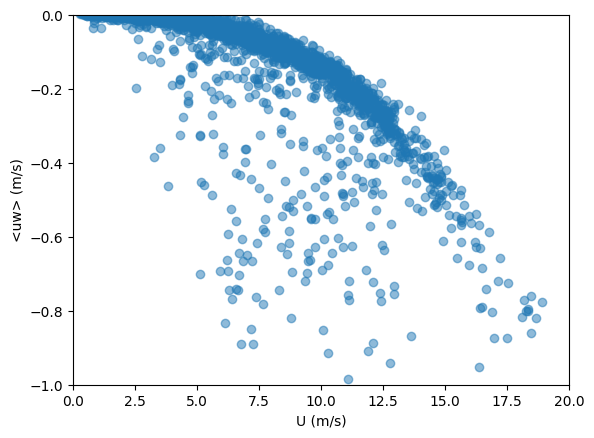

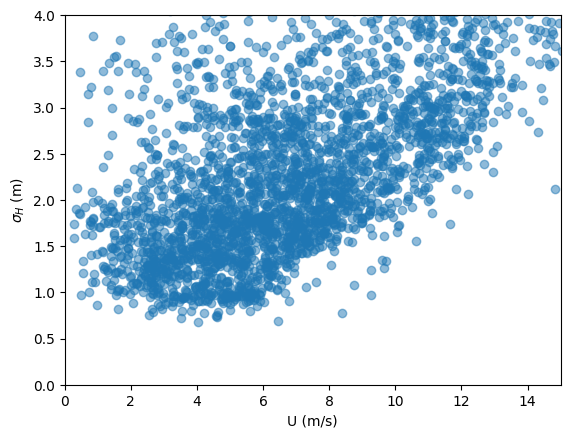

In [6]:
from examples.fdchp.plot_fdchp import plot_x_velocity_vs_wind_speed, plot_wave_height_vs_wind_speed

plot_x_velocity_vs_wind_speed(U, uw)

plot_wave_height_vs_wind_speed(U, sigH)

In [7]:
files = []
# data_directory = '/home/jovyan/ooi/uncabled/GI01SUMO/R00007/instruments/dcl12/FDCHP_sn143401/D202108'
for data_directory in data_directories2021:
    directory_files = glob(os.path.join(data_directory, '*.dat'))
    files += directory_files

U=[]
uw=[]
sigH=[]
times=[]
data = []

output_filepath = "2021/fluxes"
output_filename = "fluxes{}"
errors = {}

if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
print("Processing {} files.".format(len(files)))
incr=0
print("Start time: {}".format(datetime.now()))
data_readin_accumulator = timedelta(0)
data_processed_accumulator = timedelta(0)
# for incr in np.arange(24):
for filename in files:
    #****************************************
    # Read in raw data
    #**********************************

    start = datetime.now()
    file_basename = os.path.basename(filename)
    try:
        raw_data = read_file_to_pandas(filename)
    except Exception as e:
        print("Exception processing file {}: {}".format(filename, e))
        errors[filename] = e

    data_readin = datetime.now()
    data_readin_accumulator = data_readin_accumulator + (data_readin-start)
    #*****************************************
    # Compute flux data
    #*****************************************   
    try:
        fluxes, Uearth, waveheight = process_fdchp(raw_data, lat, instrument_rel_position, flux_filepath=os.path.join(output_filepath, output_filename.format(file_basename.split('.dat')[0])))
    except Exception as e:
        # Error processing data; probably too few datapoints
        print("Error processing fdchp dataset: {}".format(e))
        incr +=1
        errors[filename] = e
        continue
    processed = datetime.now()
    data_processed_accumulator = data_processed_accumulator + (processed-data_readin)
    if incr %100 == 0:
        print("File processing finished for file {}: {}. Read-in time: {}, Process time: {}".format(incr, file_basename, data_readin_accumulator, data_processed_accumulator))
        data_readin_accumulator = timedelta(0)
        data_processed_accumulator = timedelta(0)
    uw = uw + [fluxes[0]]        # Fluxes: uw vw wT
    U = U + [Uearth]              # Wind speed relative to earth  
    sigH = sigH + [waveheight]    # Significant wave height
    times = times + [raw_data['time'].mean()]
    incr += 1

uw = np.array(uw)
U = np.array(U)
sigH = np.array(sigH)
times = np.array(times)

print("{} errors during processing.".format(len(errors)))
print("End time: {}".format(datetime.now()))

Processing 3071 files.
Start time: 2024-11-06 15:43:45.572232
File processing finished for file 0: fdchp_20210716_220200.dat. Read-in time: 0:00:00.580997, Process time: 0:00:00.065905
File processing finished for file 100: fdchp_20210720_070200.dat. Read-in time: 0:00:53.856629, Process time: 0:00:06.690375
File processing finished for file 200: fdchp_20210730_090200.dat. Read-in time: 0:00:53.756887, Process time: 0:00:06.778425
File processing finished for file 300: fdchp_20210720_020200.dat. Read-in time: 0:00:53.331261, Process time: 0:00:06.672649
File processing finished for file 400: fdchp_20210708_150200.dat. Read-in time: 0:00:53.680658, Process time: 0:00:06.668456
File processing finished for file 500: fdchp_20210726_010200.dat. Read-in time: 0:00:53.632487, Process time: 0:00:06.679118
File processing finished for file 600: fdchp_20210711_150200.dat. Read-in time: 0:00:53.795836, Process time: 0:00:06.637797
File processing finished for file 700: fdchp_20210715_230200.dat.

## Plot the data

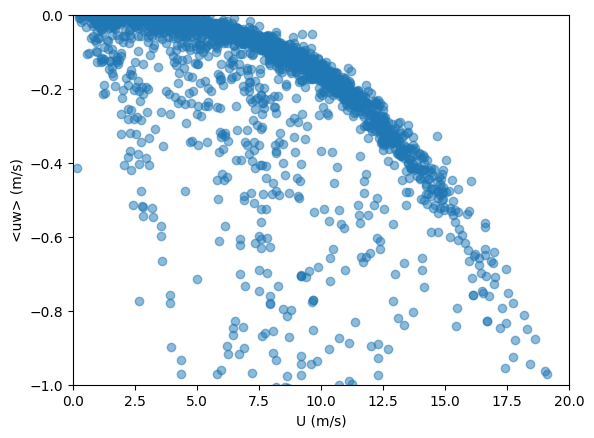

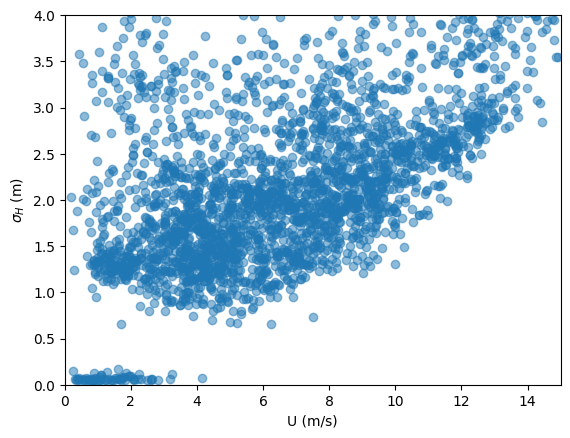

In [8]:
from examples.fdchp.plot_fdchp import plot_x_velocity_vs_wind_speed, plot_wave_height_vs_wind_speed

plot_x_velocity_vs_wind_speed(U, uw)

plot_wave_height_vs_wind_speed(U, sigH)

In [9]:
# flux_files = glob(output_filepath+'/*')

# times = []
# for flux_file in flux_files:
#     with open(flux_file) as infile:
#         ff = infile.read()
#         time = datetime.fromisoformat(ff.split(',')[0])
#     times.append(time)
# times.sort()
# times = np.array(times)

In [10]:
times_2021 = times[:]
uw_2021 = uw[:]
U_2021 = U[:]
sigH_2021 = sigH[:]
errors_2021 = dict(errors)

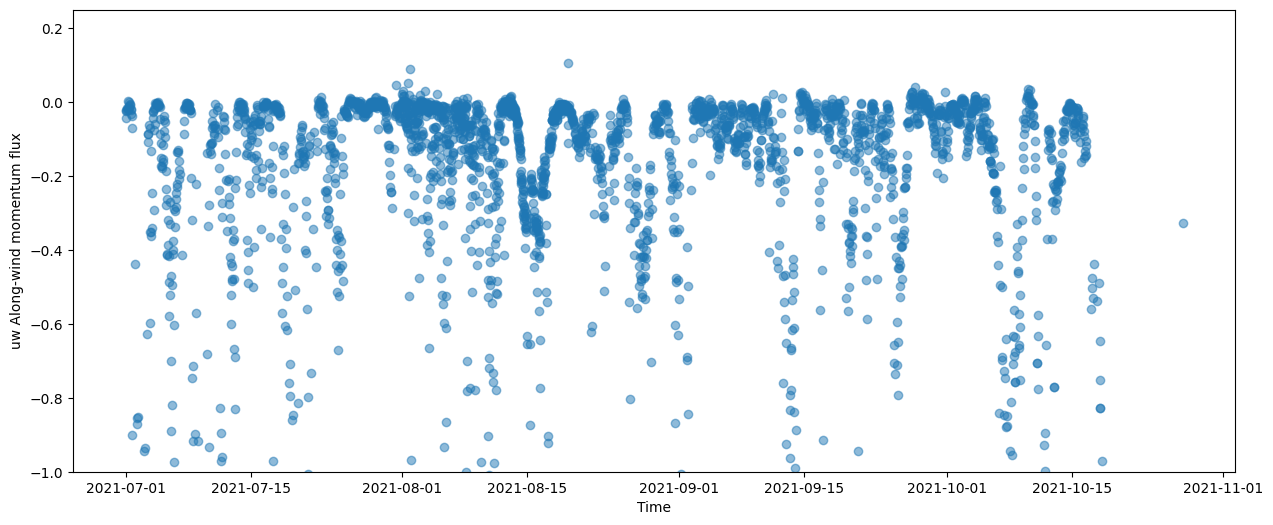

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(times_2021, uw_2021, marker='o', alpha=0.5)
ax.set_xlabel('Time')
# ax.set_xlim(0, 15)
ax.set_ylabel('uw Along-wind momentum flux')
ax.set_ylim(-1.0, 0.25)
plt.show()

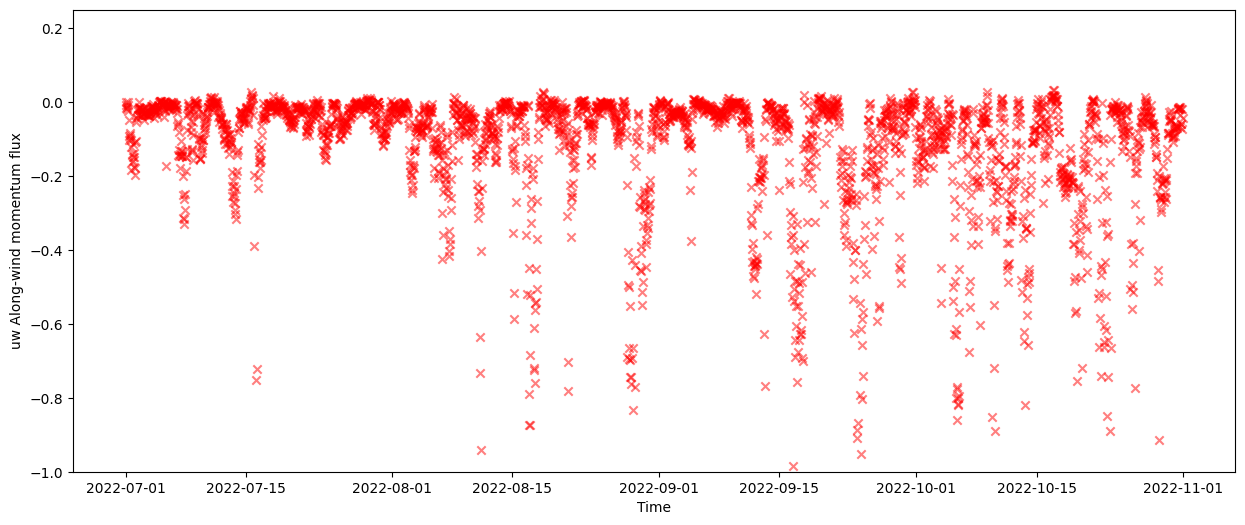

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(times_2022, uw_2022, marker='x', color='red', alpha=0.5)
ax.set_xlabel('Time')
# ax.set_xlim(0, 15)
ax.set_ylabel('uw Along-wind momentum flux')
ax.set_ylim(-1.0, 0.25)
plt.show()

In [16]:
telemetered_files_2022_all = glob("/home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-telemetered-fdchp_a_dcl_instrument/deployment0009_GI01SUMO-SBD12-08-FDCHPA000-telemetered-fdchp_a_dcl_instrument_2022*.nc")
recovered_files_2021_all = glob("/home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment000*_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_2021*.nc")
recovered_files_2022_all = glob("/home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0009_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_2022*.nc")

In [17]:
DATES_PATTERN=r'.*\w(\d\d\d\d\d\d\d\dT\d\d\d\d\d\d.\d+)-(\d\d\d\d\d\d\d\dT\d\d\d\d\d\d.\d+)+(?:\r\n|\n)?'
filename_datetime_regex = re.compile(DATES_PATTERN)

start_date_2022 = np.min(times_2022)
end_date_2022 = np.max(times_2022)
files = []
for filename in telemetered_files_2022_all:
    fname = os.path.basename(filename)
    file_name_date_match = filename_datetime_regex.match(fname)
    first_date = pd.to_datetime(file_name_date_match.group(1), format='%Y%m%dT%H%M%S.%f')
    second_date = pd.to_datetime(file_name_date_match.group(2), format='%Y%m%dT%H%M%S.%f')
    if(first_date < end_date_2022 and second_date > start_date_2022):
        files.append(filename)
telemetered_files_2022 = list(files)
telemetered_files_2022.sort()

files = []
for filename in recovered_files_2022_all:
    fname = os.path.basename(filename)
    file_name_date_match = filename_datetime_regex.match(fname)
    first_date = pd.to_datetime(file_name_date_match.group(1), format='%Y%m%dT%H%M%S.%f')
    second_date = pd.to_datetime(file_name_date_match.group(2), format='%Y%m%dT%H%M%S.%f')
    if(first_date < end_date_2022 and second_date > start_date_2022):
        files.append(filename)
recovered_files_2022 = list(files)
recovered_files_2022.sort()


start_date_2021 = np.min(times_2021)
end_date_2021 = np.max(times_2021)
files = []
for filename in recovered_files_2021_all:
    fname = os.path.basename(filename)
    file_name_date_match = filename_datetime_regex.match(fname)
    first_date = pd.to_datetime(file_name_date_match.group(1), format='%Y%m%dT%H%M%S.%f')
    second_date = pd.to_datetime(file_name_date_match.group(2), format='%Y%m%dT%H%M%S.%f')
    if(first_date < end_date_2021 and second_date > start_date_2021):
        files.append(filename)
recovered_files_2021 = list(files)
recovered_files_2021.sort()

In [19]:
netcdf_path_2021_telemetered_0 = "/home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-telemetered-fdchp_a_dcl_instrument/deployment0007_GI01SUMO-SBD12-08-FDCHPA000-telemetered-fdchp_a_dcl_instrument_20200817T182205.960000-20210819T062159.120000.nc"
netcdf_path_2021_telemetered_1 = "/home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-telemetered-fdchp_a_dcl_instrument/deployment0008_GI01SUMO-SBD12-08-FDCHPA000-telemetered-fdchp_a_dcl_instrument_20210812T172204.446000-20211019T062200.467000.nc"
ds2021_0 = xr.open_dataset(netcdf_path_2021_telemetered_0).swap_dims({"obs": "time"})
ds2021_1 = xr.open_dataset(netcdf_path_2021_telemetered_1).swap_dims({"obs": "time"})
ds2021_telemetered = xr.merge([ds2021_0, ds2021_1])

In [20]:
vars_to_drop = [
            key for key in ds2021_0.data_vars if 'flux' not in key
        ] + ["obs", "lat", "lon", "depth", "fdchp_a_time_L1", "fdchp_a_time_L2"]


In [21]:
vars_to_drop

['wind_w_max_qc_executed',
 'speed_of_sound_min',
 'pitch',
 'wind_w_avg_qc_results',
 'pitch_min',
 'u_corr_std',
 'wind_v_min_qc_executed',
 'z_accel_std',
 'wind_v_max',
 'y_ang_rate_avg',
 'w_corr_qc_executed',
 'w_corr_std',
 'x_ang_rate_std',
 'wind_speed',
 'speed_of_sound_avg_qc_results',
 'y_ang_rate_min',
 'wind_u_avg',
 'y_ang_rate_max',
 'y_ang_rate_std',
 'port_timestamp',
 'v_corr_std',
 'heading_std',
 'wind_u_std',
 'deployment',
 'pitch_max',
 'w_corr_qc_results',
 'status_datacollection',
 'preferred_timestamp',
 'u_corr_qc_results',
 'v_corr_qc_results',
 'wind_u_max_qc_results',
 'wind_u_max',
 'heading',
 'wind_v_min_qc_results',
 'roll_min',
 'speed_of_sound_avg_qc_executed',
 'driver_timestamp',
 'heading_max',
 'wind_u_avg_qc_results',
 'x_accel',
 'pitch_std',
 'speed_of_sound_min_qc_results',
 'instrument_start_timestamp',
 'speed_of_sound_max_qc_executed',
 'wind_u_min_qc_executed',
 'eng_wave_motion',
 'speed_of_sound_std',
 'wind_v_min',
 'heading_min',
 's

In [22]:
del ds2021_0
del ds2021_1

In [23]:
datasets = []
for file in telemetered_files_2022:
    ds = xr.open_dataset(file).swap_dims({"obs": "time"})
    ds = ds.drop_vars(vars_to_drop, errors="ignore")
    datasets.append( ds )

ds2022_telemetered = xr.merge(datasets)

In [24]:
ds_recovered_example = xr.open_dataset(recovered_files_2021[0]).swap_dims({"obs": "time"})

In [26]:
for ds in datasets:
    del ds

In [27]:
vars_to_drop_recovered = [
            key for key in ds_recovered_example.data_vars if 'flux' not in key
        ] + ["obs", "lat", "lon", "depth","fdchp_a_time_L1"]

In [28]:
datasets = []
for file in recovered_files_2022:
    print("Processing file: {}".format(file))
    ds = xr.open_dataset(file).swap_dims({"obs": "time"})
    print("Dataset opened.")
    ds = ds.drop_vars(vars_to_drop_recovered, errors="ignore")
    print("Vars dropped.")
    mask = xr.DataArray(ds.fdchp_a_time_L2 > 1000000000.0, dims=["fdchp_a_time_L2"]) #reasonable timestamps
    ds = ds.isel(fdchp_a_time_L2 = mask)
    print("Limited to reasonable timestamps")
    datasets.append( ds )
print("Merging...")
ds2022_recovered = xr.merge(datasets)
print("Done")

Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0009_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20220630T160200.050000-20220717T022200.072000.nc
Dataset opened.
Vars dropped.
Limited to reasonable timestamps
Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0009_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20220717T030200.050000-20220802T142200.070000.nc
Dataset opened.
Vars dropped.
Limited to reasonable timestamps
Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0009_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20220802T150200.051000-20220819T022200.070000.nc
Dataset opened.
Vars dropped.
Limited to reasonable timestamps
Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000

In [30]:
for ds in datasets:
    del ds

In [31]:
datasets = []
for file in recovered_files_2021:
    print("Processing file: {}".format(file))
    ds = xr.open_dataset(file).swap_dims({"obs": "time"})
    print("Dataset opened.")
    ds = ds.drop_vars(vars_to_drop_recovered, errors="ignore")
    print("Vars dropped.")
    mask = xr.DataArray(ds.fdchp_a_time_L2 > 1000000000.0, dims=["fdchp_a_time_L2"]) #reasonable timestamps
    ds = ds.isel(fdchp_a_time_L2 = mask)
    print("Limited to reasonable timestamps")
    datasets.append( ds )
print("Merging...")
ds2021_recovered = xr.merge(datasets)
print("Done")

Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0007_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20210625T180200.095000-20210711T172159.953000.nc
Dataset opened.
Vars dropped.
Limited to reasonable timestamps
Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0007_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20210711T180200.077000-20210727T232159.965000.nc
Dataset opened.
Vars dropped.
Limited to reasonable timestamps
Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered/deployment0007_GI01SUMO-SBD12-08-FDCHPA000-recovered_inst-fdchp_a_instrument_recovered_20210728T000200.096000-20210813T112159.966000.nc
Dataset opened.
Vars dropped.
Limited to reasonable timestamps
Processing file: /home/jovyan/ooi/kdata/GI01SUMO-SBD12-08-FDCHPA000

In [36]:
for ds in datasets:
    del ds

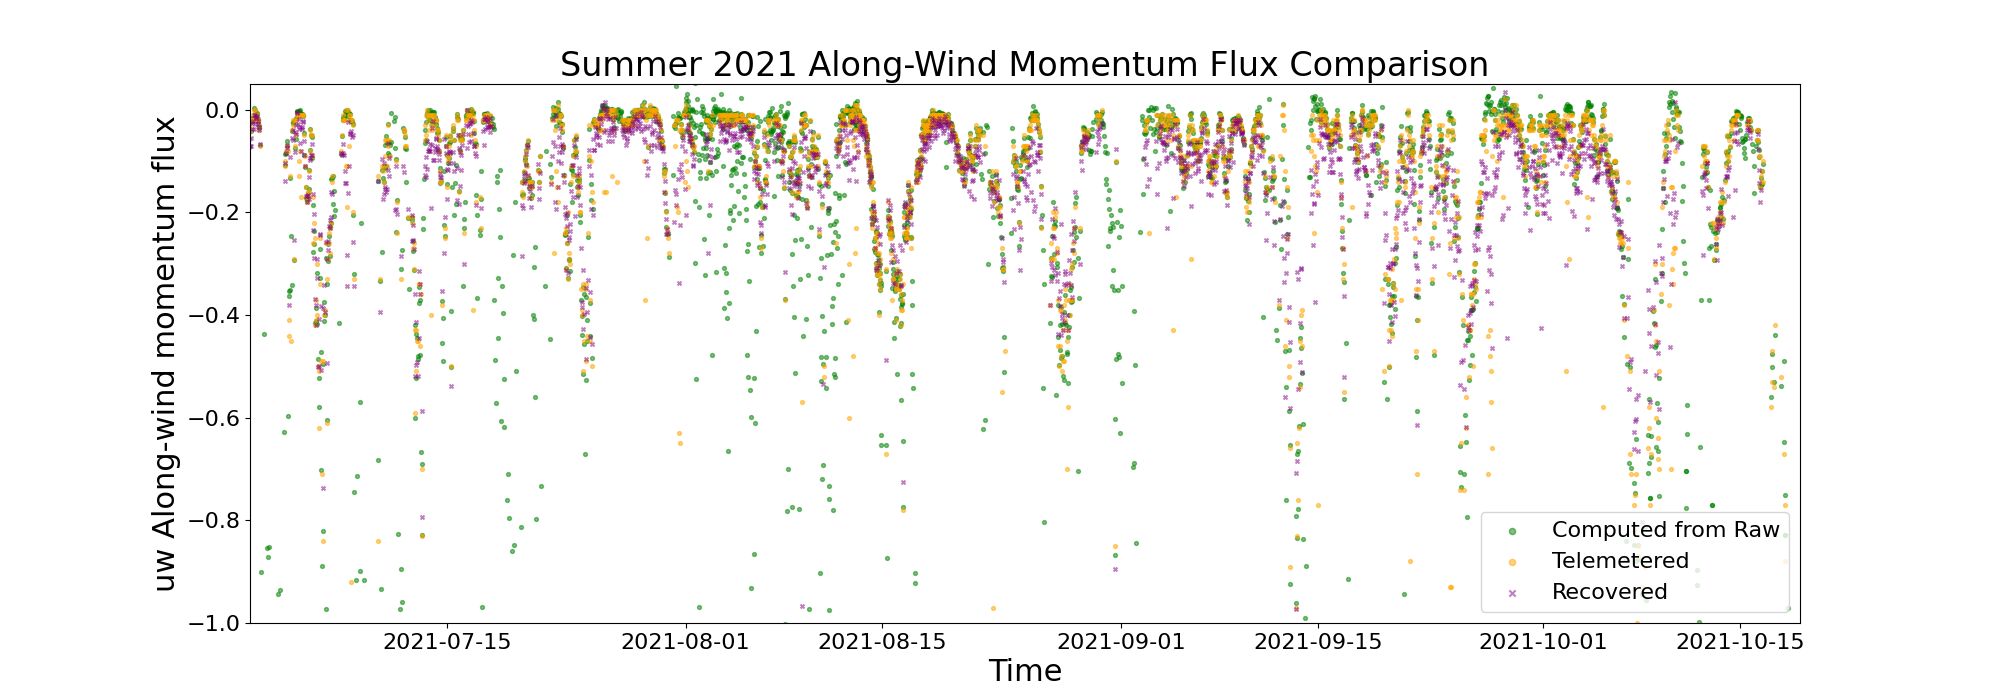

In [44]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
# %matplotlib inline
%matplotlib ipympl

time_2021_recovered = (ntplib.ntp_to_system_time(ds2021_recovered['fdchp_a_time_L2'].values)).astype('datetime64[s]')
marker_size = 8
legend_marker_size = 20
tick_size = 16

def update(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([legend_marker_size])
    
fig, ax = plt.subplots(figsize=(20, 7))
ax.scatter(times_2021, uw_2021, marker='o', color='green', s=marker_size, alpha=0.5, label="Computed from Raw")
ax.scatter(ds2021_telemetered['time'], ds2021_telemetered['uw_momentum_flux'], marker='o', color='orange', s=marker_size, alpha=0.5, label="Telemetered")
scatter = ax.scatter(time_2021_recovered, ds2021_recovered['fdchp_a_fluxmom_alongwind'], marker='x', color='purple', s=marker_size, alpha=0.5, label="Recovered")
ax.set_xlabel('Time', fontsize=22)
ax.set_xlim(np.min(times_2021), np.max(ds2021_telemetered['time'].values))
ax.set_ylabel('uw Along-wind momentum flux', fontsize=22)
ax.set_ylim(-1.0, 0.05)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend = ax.legend(loc="lower right", fontsize=tick_size, handler_map={PathCollection : HandlerPathCollection(update_func=update)})
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("Summer 2021 Along-Wind Momentum Flux Comparison", fontsize=24)
plt.savefig('summer_2021_comparison.png', bbox_inches='tight')
plt.show()

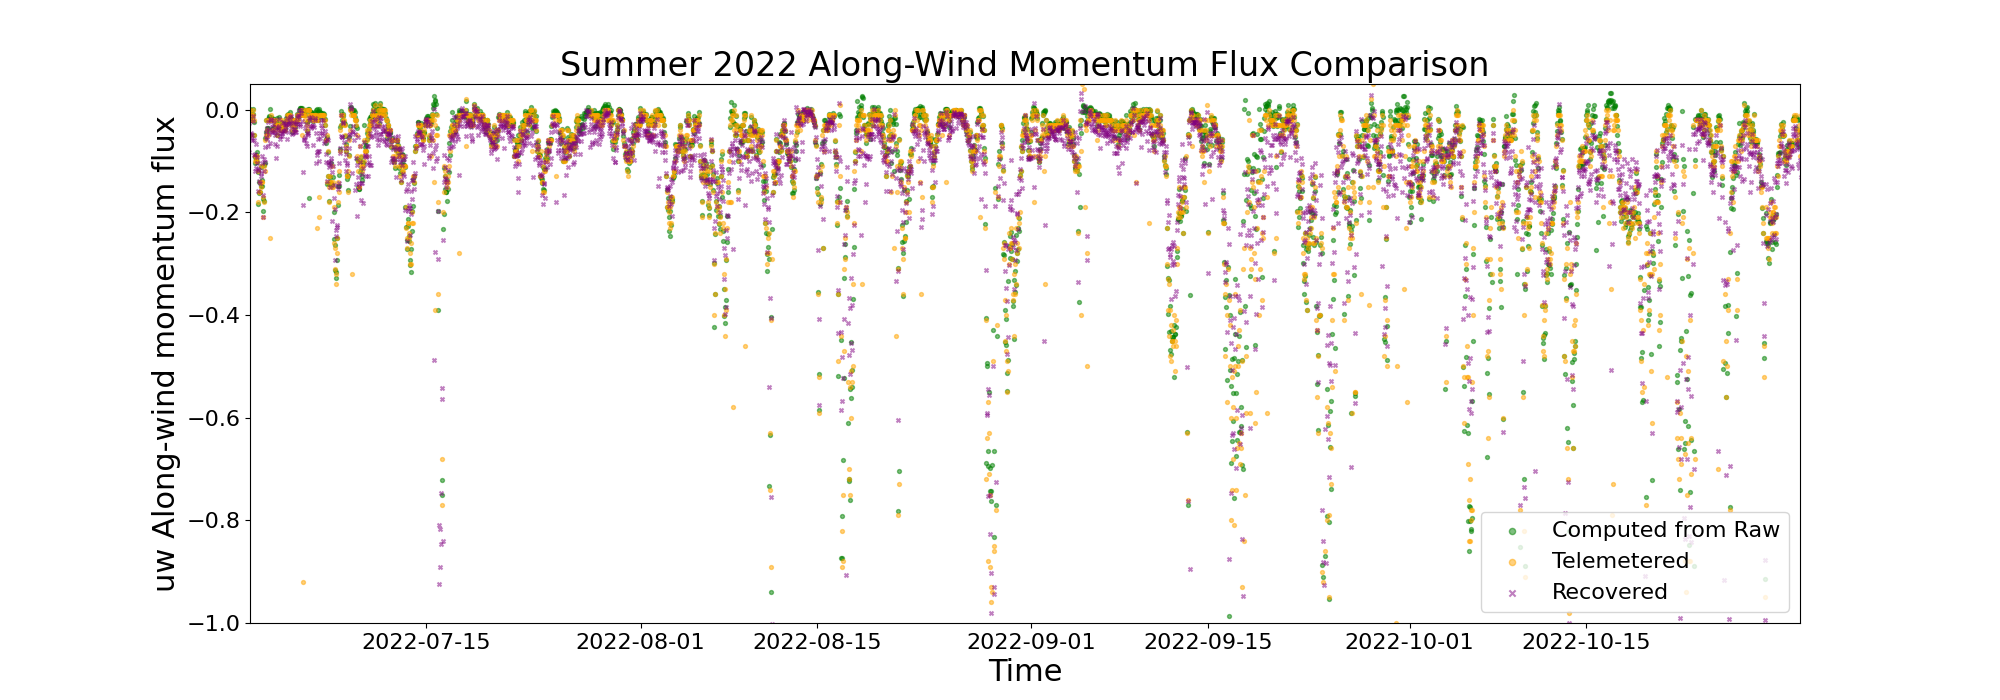

In [45]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
# %matplotlib inline
%matplotlib ipympl

time_2022_recovered = (ntplib.ntp_to_system_time(ds2022_recovered['fdchp_a_time_L2'].values)).astype('datetime64[s]')
marker_size = 8
legend_marker_size = 20
tick_size = 16

def update(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([legend_marker_size])
    
fig, ax = plt.subplots(figsize=(20, 7))
ax.scatter(times_2022, uw_2022, marker='o', color='green', s=marker_size, alpha=0.5, label="Computed from Raw")
ax.scatter(ds2022_telemetered['time'], ds2022_telemetered['uw_momentum_flux'], marker='o', color='orange', s=marker_size, alpha=0.5, label="Telemetered")
scatter = ax.scatter(time_2022_recovered, ds2022_recovered['fdchp_a_fluxmom_alongwind'], marker='x', color='purple', s=marker_size, alpha=0.5, label="Recovered")
ax.set_xlabel('Time', fontsize=22)
ax.set_xlim(np.min(times_2022), np.max(times_2022))
ax.set_ylabel('uw Along-wind momentum flux', fontsize=22)
ax.set_ylim(-1.0, 0.05)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend = ax.legend(loc="lower right", fontsize=tick_size, handler_map={PathCollection : HandlerPathCollection(update_func=update)})
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title("Summer 2022 Along-Wind Momentum Flux Comparison", fontsize=24)
plt.savefig('summer_2022_comparison.png', bbox_inches='tight')
plt.show()

## Output data in csv format

In [59]:
df_2022_recovered = ds2022_recovered[['fdchp_a_time_L2','fdchp_a_fluxmom_alongwind']].to_dataframe()
df_2022_recovered.to_csv("recovered_2022.csv")
df_2021_recovered = ds2021_recovered[['fdchp_a_time_L2','fdchp_a_fluxmom_alongwind']].to_dataframe()
df_2021_recovered.to_csv("recovered_2021.csv")

df_2022_telemetered = ds2022_telemetered[['time','uw_momentum_flux']].to_dataframe()
df_2022_telemetered.to_csv("telemetered_2022.csv")
df_2021_telemetered = ds2021_telemetered[['time','uw_momentum_flux']].to_dataframe()
df_2021_telemetered.to_csv("telemetered_2021.csv")

df_2021_calculated = pd.DataFrame({"time":times_2021, 'uw_momentum_flux': uw_2021})
df_2021_calculated.to_csv("calculated_2021.csv")
df_2022_calculated = pd.DataFrame({"time":times_2022, 'uw_momentum_flux': uw_2022})
df_2022_calculated.to_csv("calculated_2022.csv")